## Lighthouse Labs
### W05D02 Logistic Regression
Instructor: Socorro Dominguez  
October 13, 2020

In [1]:
from sklearn.model_selection import train_test_split 
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.metrics import confusion_matrix, roc_curve, f1_score, roc_auc_score
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier 

# Other
import numpy as np
import pandas as pd
import pickle 
from sklearn import datasets
from plot_classifier import plot_classifier
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [3]:
import plotly.io as pio # conda install -c plotly plotly-orca
from IPython.display import Image

In [4]:
plt.rcParams['font.size'] = 16

In [5]:
%autosave 0

Autosave disabled


In [33]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

**Agenda:**

* Limitations of Linear Regression
* Logistic regression
    * Odds
    * Log-odds
    * Odds ratio
    * Multinomial logistic regresion (softmax)
* GLM (generalised linear models)

### Limitations for Linear Regression

In Regression, we allow the response to take on any real number. But what if the range is restricted?

1. Positive values: river flow. 
    - Lower limit: 0
2. Percent/proportion data: proportion of income spent on housing in Vancouver. 
    - Lower limit: 0
    - Upper limit: 1. 
3. Binary data: success/failure data.
    - Only take values of 0 and 1.
4. Count data: number of male crabs nearby a nesting female
    - Only take count values (0, 1, 2, ...)

In [7]:
cow = pd.read_csv("data/milk_fat.csv")

Here is an example of the fat content of a cow's milk, which was recorded over time. Data are from the paper ["Transform or Link?"](https://core.ac.uk/download/pdf/79036775.pdf). 

In [8]:
cow.head()

,week,fat
0,1,0.31
1,2,0.39
2,3,0.50
3,4,0.58
4,5,0.59


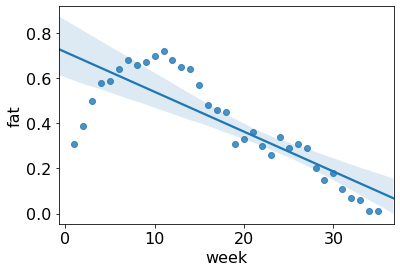

In [9]:
sns.regplot(cow['week'],cow['fat'])

In [10]:
from sklearn.linear_model import LinearRegression
X = cow['week'].values.reshape(-1, 1)
# y = 1 * x_0 + 2 * x_1 + 3
y = cow['fat'].values.reshape(-1, 1)
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.6801635017906559

In [11]:
reg.predict(np.array([41]).reshape(1, 1))

array([[-0.00789076]])

Notice the problem here -- __the regression lines extend beyond the possible range of the response__. This is *mathematically incorrect*, since the expected value cannot extend outside of the range of Y. But what are the *practical* consequences of this?

In practice, when fitting a linear regression model when the range of the response is restricted, we lose hope for extrapolation, as we obtain logical fallacies if we do. In this example, a cow is expected to produce _negative_ fat content after week 40!

Despite this, a linear regression model might still be useful in these settings. After all, the linear trend looks good for the range of the data. 


## Solutions

How can we fit a regression curve to stay within the bounds of the data, while still retaining the interpretability that we have with a linear model function? Here are some options:

1. Transform the data. 
2. Transform the linear model function: link functions
3. Use a scientifically-backed parametric function.

### Solution 1: Transformations

One solution that _might_ be possible is to transform the response so that its range is no longer restricted. 
The most typical example is for positive data, like the fat content. If we log-transform the response, then the new response can be any real number. All we have to do is fit a linear regression model to this transformed data.

But transforming the response might not always be fruitful. For example, consider a binary response. No transformation can spread the two values to be non-binary!

### Solution 2: Link Functions

Instead of transforming the data, why not transform the model function? For example, instead of taking the logarithm of the response, perhaps fit the model $$ E(Y|X=x) = \exp(\beta_0 + \beta x) = \alpha \exp(\beta x). $$ Or, in general, $$ g(E(Y|X=x)) = X^{\top} \beta $$ for some increasing function $g$ called the _link function_. 

This has the added advantage that we do not need to be able to transform the response.

Two common examples of link functions:

- $\log$, for positive response values.
    - Parameter interpretation: an increase of one unit in the predictor is associated with an $\exp(\beta)$ times increase in the mean response, where $\beta$ is the slope parameter.
- $\text{logit}(x)=\log(x/(1-x))$, for binary response values.
    - Parameter interpretation: an increase of one unit in the predictor is associated with an $\exp(\beta)$ times increase in the odds of "success", where $\beta$ is the slope parameter, and odds is the ratio of success to failure probabilities.

### Logistic Regression

The first thing to say is that logistic regression is not a regression, but a classification learning algorithm. The name comes from statistics and is due to the fact that the mathematical formulation of logistic regression is similar to that of linear regression.

But before we jump in there, let's define odds and log of odds.

### Odds

The **probability** that an event will occur is the fraction of times you expect to see that event in many trials. 
Probabilities always range between 0 and 1. 

The **odds** are defined as the probability that the event will occur divided by the probability that the event will not occur.  
$\frac{y}{(1-y)}$

* If a race horse runs 100 races and wins 25 times and loses the other 75 times, the probability of winning is 25/100 = 0.25 or 25%. The odds of the horse winning are 25/75 = 0.333 or 1 win to 3 loses.

* If the horse runs 100 races and wins 5 and loses the other 95 times, the probability of winning is 0.05 or 5%, and the odds of the horse winning are 5/95 = 0.0526.

* If the horse runs 100 races and wins 50, the probability of winning is 50/100 = 0.50 or 50%, and the odds of winning are 50/50 = 1 (even odds).

* If the horse runs 100 races and wins 80, the probability of winning is 80/100 = 0.80 or 80%, and the odds of winning are 80/20 = 4 to 1.

What would happen if the horse is too bad at racing? What would happen if the horse is the best? 

If the horse is too bad, the odds of winning will tend to zero.

But if the horse is too good, the odds of winning will be too high.... they can reach infinity... 

How can we compare?

**Log Odds**  
So now that we understand Odds and Probability, we can understand Log Odds. 

Log of Odds is nothing but log(odds). Log Odds makes the magnitude of odds against look so much smaller to those in favor.

When we take a log of odds, we make it look symmetrical.

$Logit Function = log\frac{p}{1-p}$

Odds of winning = 4/6 = 0.6666  
log(Odds of winning) = log(0.6666) = -0.176  
Odds of losing = 6/4 = 1.5  
log(Odds of losing) = log(1.5) = 0.176  

The value of the logit function heads towards infinity as p approaches 1 and towards negative infinity as it approaches 0.

The logit function is useful in analytics because it maps probabilities (which are values in the range [0, 1]) to the full range of real numbers. In particular, if you are working with “yes-no” (binary) inputs it can be useful to transform them into real-valued quantities prior to modeling. This is essentially what happens in logistic regression.

The inverse of the logit function is the sigmoid function. That is, if you have a probability p, sigmoid(logit(p)) = p. The sigmoid function maps arbitrary real values back to the range [0, 1]. 

The larger the value, the closer to 1 you’ll get.

The formula for the sigmoid function is $\sigma(x) = \frac{1}{(1 + exp^{-x})}$ . 

Here is a plot of the function:

![sigmoid](img/sigmoid.png)

The sigmoid function is what we associate as the Logistic Regression. The sigmoid might be useful if you want to transform a real valued variable into something that represents a probability. This sometimes happens at the end of a classification process. 

There are other functions that map probabilities to reals (and vice-versa), so what is special about the logit and sigmoid? 
- The logit function has the nice connection to odds described at the beginning. Even if we associate LogReg with the squiggly line, we CANNOT forget that the COEFFICIENTS ARE presented in terms of the log(odds) graph.

- Gradients of the logit and sigmoid are simple to calculate. Many optimization and ML techniques use gradients.

The biggest drawback of the sigmoid function is the so-called “vanishing gradient” problem (the gradient is vanishingly small, preventing the weight from changing its value).

How does the Sigmoid Function work in Classification Problems?

1. Sigmoid Function has a property of converting what is passed into it to a value between 0 and 1
2. If value is above a threshold it is 1
3. if value is below a threshold, it is 0
4. threshold is generally 0.5
5. We can say that the Sigmoid Function is a special case of the Softmax function when we only have two classes. - More later-

**In class complicated demo**

We will be using a small dataset of [IMDB movie review data set](https://www.kaggle.com/utathya/imdb-review-dataset). Only 5,000 IMDB reviews (compared to 50,000 examples in the original data). Note that more data is usually better. 

In [12]:
# Read IMDB movie reviews into a pandas DataFrame
imdb_df = pd.read_csv('data/imdb_master.csv', encoding = "ISO-8859-1")
imdb_df.head()


,Unnamed: 0,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [13]:
# For converting words into frequency counts
from sklearn.feature_extraction.text import CountVectorizer
# For tokenization
import nltk

# Only keep the reviews with pos and neg labels
imdb_df = imdb_df[imdb_df['label'].str.startswith(('pos','neg'))]

# Sample 5000 rows from the dataframe. 
imdb_df_subset = imdb_df.sample(n = 5000)

# Convert a collection of text documents to a matrix of token presence or absence. 
# We are using only 5000 words, English stopwords, and tokenization is done using
# nltk, which is a popular text processing library.
movie_vec = CountVectorizer(max_features=5000, 
                            tokenizer=nltk.word_tokenize, 
                            stop_words='english', 
                            binary = True)
# Create X and y
X_imdb = movie_vec.fit_transform(imdb_df_subset['review'])
y_imdb = imdb_df_subset.label


In [34]:
from sklearn.linear_model import LogisticRegression
X_train, X_test, y_train, y_test = train_test_split(X_imdb, 
                                                    y_imdb, 
                                                    test_size = 0.20)


lr = LogisticRegression()
lr.fit(X_train, y_train);
lr.score(X_test, y_test)

0.852

In [15]:
vocab = movie_vec.get_feature_names()

In [16]:
pd.DataFrame(lr.intercept_)

,0
0,0.70639


In [17]:
pd.DataFrame(lr.coef_, columns= vocab)

,!,#,$,%,&,','','d,'em,'ll,...,younger,youth,youthful,youtube,zero,zombie,zombies,zone,},â
0,0.260464,0.194756,0.028814,-0.429379,-0.218231,-0.042182,0.212475,0.20574,-0.139505,0.100163,...,0.009213,-0.433951,0.197481,0.173388,-0.454189,0.12738,0.021886,0.107966,0.115549,0.220461


When we are looking at the coefficients, it is important to think what kind of line are we seeing. Remember that the y-axis is transformed from probability to log(odds). 

Now, just like the y-axis in linear regression, this line can go from -∞ to ∞.

If we had a different dataframe, with just two variables, we would see a dividing line, commonly called **Decision Boundary** 

Remember, this is the line where we would interpret our coefficients. 

![img](img/log.png)

In [19]:
## SOLUTION
inds = np.argsort(lr.coef_.flatten())
negative_words = [vocab[index] for index in inds[:10]]
positive_words = [vocab[index] for index in inds[-10:]]
print("Most negative words: %s" % ", ".join(negative_words))
print("Most positive words: %s" % ", ".join(positive_words))

Most negative words: worst, disappointing, waste, laughable, boring, stupid, poorly, 4, 4/10, disappointment
Most positive words: great, highly, enjoyable, superb, brilliant, buy, 7/10, loved, favorite, excellent


**Model Evaluation**

We don't always evaluate a model based on accuracy.

A confusion matrix is a table that allows us evaluate the performance of a classification model. You can also visualize the performance of an algorithm. The fundamental of a confusion matrix is the number of correct and incorrect predictions are summed up class-wise.

In [20]:
from sklearn import metrics
y_pred=lr.predict(X_test)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[432,  63],
       [ 86, 419]])

In [21]:
TN, FP, FN, TP = metrics.confusion_matrix(y_test, y_pred).ravel()

**Accuracy:** Proportion of correct predictions (both true positives and true negatives) among the total number of cases examined.

In [22]:
accuracy = (TP+TN)/(TN+FP+FN+TP)
accuracy

0.851

**Precision:** Fraction of predicted positives that are actually positive.

In [23]:
precision = TP/(TP+FP) 
precision

0.8692946058091287

**Recall:** Fraction of true positives that are predicted positive

In [24]:
recall = TP/(TP+FN)
recall

0.8297029702970297

**ROC Curve**  

The Receiver Operating Characteristic curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.

Area Under the Curve shows us how good a classifier is: 1 represents perfect classifier, and 0.5 represents a worthless classifier.

The ROC curve is given by the different confusion matrices we can create with one model if we change the threshold.

In [25]:
y_test = y_test.replace('pos', 1)
y_test = y_test.replace('neg', 0)
y_test

35872    0
25274    0
27703    0
10405    0
29149    0
        ..
41086    1
11891    0
9129     0
23293    1
39921    1
Name: label, Length: 1000, dtype: int64

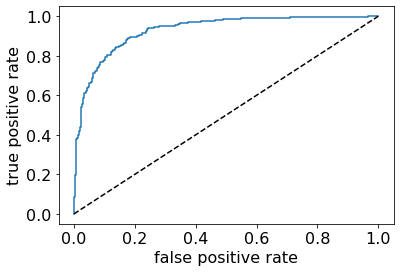

In [26]:
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr);
plt.plot((0,1),(0,1),'--k');
plt.xlabel('false positive rate');
plt.ylabel('true positive rate');

In [27]:
auc = metrics.roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
auc

0.928980898089809

### Multi-class, meta-strategies


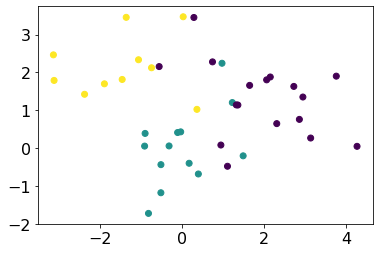

In [28]:
# make up some fake data
np.random.seed(0)
n = 40
X = np.random.randn(n,2)
y = np.random.choice((0,1,2),size=n)
X[y==0,0] += 2
X[y==0,1] += 1.5
X[y==2,0] -= 1.5
X[y==2,1] += 2

plt.scatter(X[:,0], X[:,1], c=y)
# plt.legend(loc="best")
plt.show()

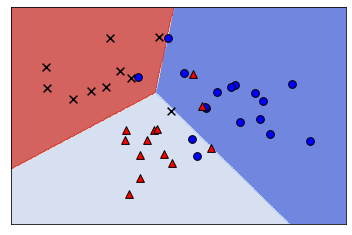

In [29]:
lr = LogisticRegression()
lr.fit(X,y)
plot_classifier(X,y, lr);

Above: 

- Uses "one-vs-rest" scheme (also known as one-vs-all)
  - turns $k$-class classification into $k$ binary classification problems
  - each one gives a probability of that class
  - take the max probability across classifiers as the class
  - you can do this yourself for any binary classifier using the meta-classifier [`OneVsRestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html)

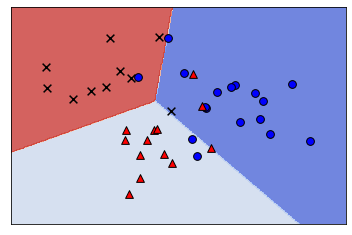

In [30]:
ovr = OneVsRestClassifier(LogisticRegression())
ovr.fit(X,y)
plot_classifier(X,y, ovr);

Here's how one-vs-rest works:

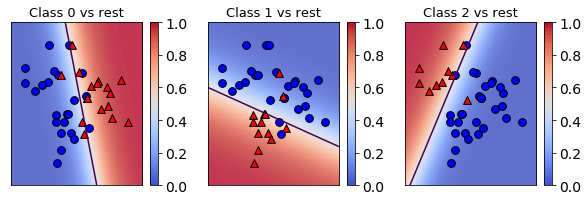

In [31]:
def one_vs_rest_plots(model_class, X, y):
    plt.figure(figsize=(10,3))
    classes = np.unique(y)
    k = len(classes)
    for i,c in enumerate(classes):
        plt.subplot(1,k,i+1)
        
        y_binary = y == c
        model = model_class()
        model.fit(X, y_binary)
        plot_classifier(X, y_binary, model, ax=plt.gca(), proba=True, proba_showtitle=False);
        plt.title("Class %d vs rest" % c, fontsize=13);
        
one_vs_rest_plots(LogisticRegression, X, y)

Above: one-vs-rest predicts by taking the max of the 3 probabilities at any given point.

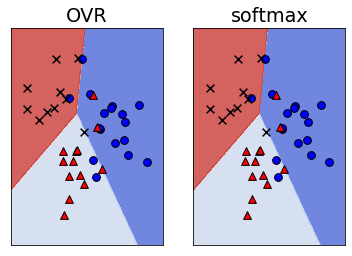

In [32]:
plt.figure()
plt.subplot(1,2,1)
lr = LogisticRegression()
lr.fit(X,y)
plot_classifier(X, y, lr, ax=plt.gca());
plt.title("OVR");
plt.subplot(1,2,2)
lr = LogisticRegression(multi_class="multinomial", solver="lbfgs")
lr.fit(X,y)
plot_classifier(X, y, lr, ax=plt.gca());
plt.title("softmax");

Above:

- Setting `multi_class="multinomial"` uses something called a "softmax" - more on this later too.
- An analogous approach exists for SVM - more of that on Thursday - but it's not implemented in scikit-learn.
- It's unclear if one of the two versions is strictly superior here, but we'll need the softmax for neural networks.

It's not that likely for you to need `OneVsRestClassifier` or [`OneVsOneClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html) because most of the methods you'll use will have native multi-class support. However, it's good to know in case you ever need to extend a binary classifier (perhaps one you've implemented from a recent publication, or who knows).

Softmax Function

- To use a neural net for classification, we take advantage of the fact that the output doesn't have to be 1-dimensional ($k>1$)
- For example, with the digits dataset there are $10$ classes, so we set the size of the last layer to $k=10$ and use a _one-hot encoding_ for the data
- We can then use the softmax loss - in other words, we're doing logistic regression using the "features" learned by all previous layers

![softmax](img/softmax.png)

As you can see, if we only had two classes, the Softmax function simplifies to our previous Sigmoid Function.

But, eventually, we will have more classes and we will make use of Softmax function to classify accordingly.

## GLM's

Since Logistic Regression has class 1s and 0s it is a binomial distribution and not a Normal Distribution

GLM's use a link function to connect the linear model to a model that predicts for non normal distribution. As we saw earlier, our link function was the Sigmoid Function.

Generalized Linear Model (GLM) is a generalization of ordinary linear regression that allows for response variables that have error distribution models other than a normal distribution. (Counts of male crabs around a nesting female?)

When you fit a GLM, you already have the information needed to produce a probabilistic forecast. This is because, in addition to specifying the relationship between the predictors and the mean, we also specify a distribution of the response (such as Poisson, Bernoulli, or Gaussian).

You will do a small exercise today on this. And it will be clearer.

Unfortunately, the implementations are better seen in R or using statsmodel library in Python.

### Why people use linear classifiers

Logistic regression are used EVERYWHERE!

- Fast training and testing.
  - Training on huge datasets.
  - Testing is just computing $w^Tx_i$.
- Weights $w_j$ are easy to understand. INTERPRETABILITY
  - It's how much $x_j$ changes the prediction and in what direction.
- We can often get a good test error.
  - With many features.
- Smoother predictions than random forests.

**In Class Exercise:**

Perform a logistic regression on the Titanic Data Set.